# Modelo de Otimização para sistema híbrido de comercialização de h2v/eletricidade

H2V = Hidrogênio produzido a partir de fontes renováveis, de forma simplifcada chamado de hidrogênio verde.

Este modelo de otimização busca encontrar o ponto ótimo de *utilização da energia elétrica produzida a partir de uma fonte renovável*, geração solar fotovoltáica.

As duas possibilidade são:
- Venda da energia produzida diratemente no mercado de eletricidade de curto-prazo;
- Utilização da energia gerada para produção da H2V

Outra possibilidade é o armazenamento de parte da energia gerada pela(s) fonte(s) renovável(is) em um dispositivo de armazenamento, que pode ser pensado tanto como uma bateria de íons de Lítio, ou um tanque de armazenamento de Hidrogênio, após sua produção via processo de eletrólise. 

In [30]:
# importação das bibliotecas necessárias

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pyomo.environ as pyo

## Carregamento de dados para preenchimento dos parâmetros

- Dados de carga
- Dados de geração PV
- Dados de preço de comercialização de energia no mercado de eletricidade
- Dados de preço de comercialização de H2V

In [31]:
from load_data import get_load_data, get_gen_data, get_spot_prices_data

In [32]:
# Algumas configurações dos valores de carga, geração e armazenamento a serem carregados

load_max = 5e3
gen_max = 50e3
index = 45

# Sistema de armazenamento de hidrogênio

h2v_storage_size_wh = 20.0e3 # unidade em wh
h2v_storage_rate = 0.1
h2v_storage_min_soc = 0.1 * h2v_storage_size_wh
h2v_storage_max_soc = 0.95 * h2v_storage_size_wh

In [33]:
load = get_load_data(index)[:96] * load_max
sload = np.sqrt(load.pload**2 + load.qload**2)
load

,pload,qload
0,580.850,1271.06
1,612.245,1271.06
2,580.850,1271.06
3,580.850,1290.92
4,573.000,1211.48
...,...,...
91,408.165,1231.34
92,392.465,1271.06
93,384.615,1231.34
94,361.070,1231.34


In [34]:
time = np.array(load.index)
time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

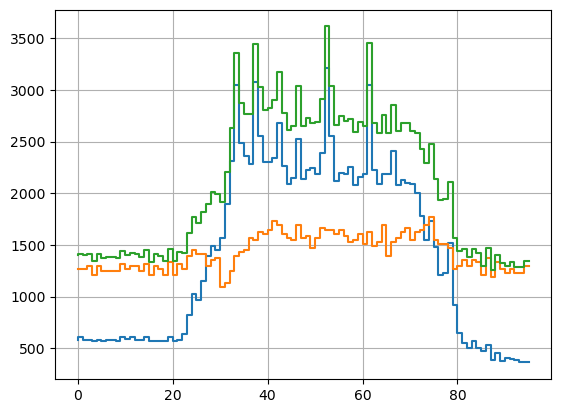

In [35]:
plt.step(time, load.pload, time, load.qload, time, sload)
plt.grid(True)

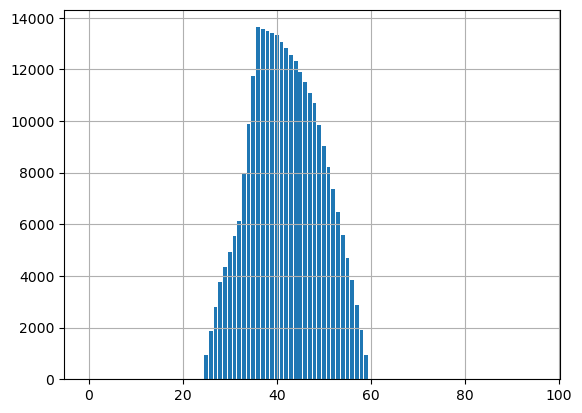

In [36]:
pv_gen = get_gen_data(index)[:96] * gen_max

plt.bar(time, pv_gen.pgen)
plt.grid(True)

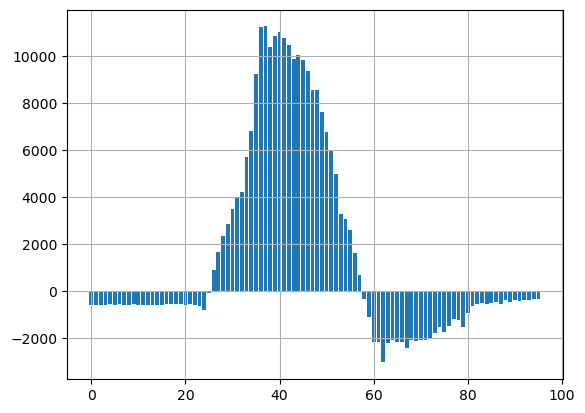

In [37]:
net_demand = pv_gen.pgen - load.pload

plt.bar(time, net_demand)
plt.grid(True)

In [38]:
spot_price = get_spot_prices_data(30)[:96]

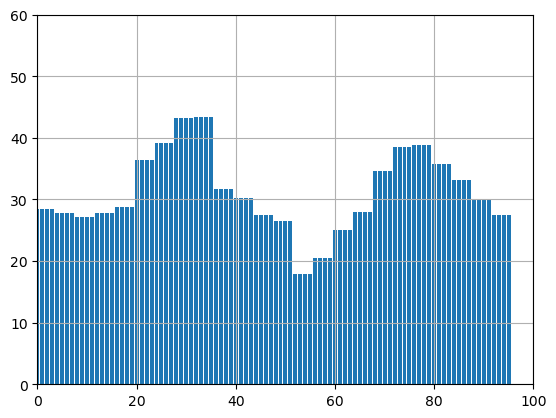

In [39]:
plt.bar(time, spot_price.Price)
plt.xlim((0.0, 100.0))
plt.ylim((0.0, 60.0))
plt.grid(True)

In [40]:
a = 0.0 # Amplitude inicial do ruído uniforme
b = 5.0 # Amplitude final do ruído uniforme
T = 100.0 # Período da senóide

h2v_min_price = 20.0
h2v_var_ampl_price = 20.0
h2v_var_func_price = np.sin(2.0 * np.pi * 1/T * time)**2
h2v_noise_price = (a + (b - a) * np.random.rand(time.size))

h2v_prices = h2v_min_price + h2v_var_ampl_price * h2v_var_func_price  + h2v_noise_price

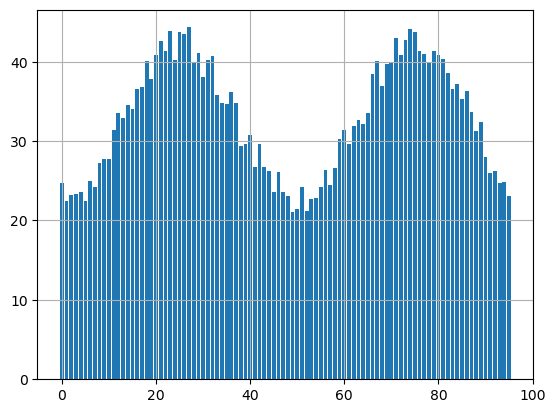

In [41]:
plt.bar(time, h2v_prices)
plt.grid(True)

In [42]:
model = pyo.ConcreteModel(name="H2V")

model.time_set = pyo.Set(initialize=time)

# Parâmetros de entrada
model.param_load = pyo.Param(model.time_set, initialize=load.pload.values, mutable=True)
model.param_pv_gen = pyo.Param(model.time_set, initialize=pv_gen.pgen.values)
model.param_spot_prices = pyo.Param(model.time_set, initialize=spot_price.Price)
model.param_h2v_prices = pyo.Param(model.time_set, initialize=h2v_prices)

# Parâmetros do módulo de armazenamento
model.max_p_charge = pyo.Param(initialize=h2v_storage_rate * h2v_storage_size_wh)
model.max_p_discharge = pyo.Param(initialize=h2v_storage_rate * h2v_storage_size_wh)
model.storage_size = pyo.Param(initialize=h2v_storage_size_wh)
model.min_soc = pyo.Param(initialize=h2v_storage_min_soc)
model.max_soc = pyo.Param(initialize=h2v_storage_max_soc)

# Variáveis de compra/venda de energia
model.var_power_to_market = pyo.Var(model.time_set, domain=pyo.PositiveReals)
model.var_power_to_h2v = pyo.Var(model.time_set, domain=pyo.PositiveReals)
model.var_power_from_grid = pyo.Var(model.time_set, domain=pyo.PositiveReals)

# Variáveis de armazenamento de energia
model.var_charging = pyo.Var(time, within=pyo.Binary)
model.var_discharging = pyo.Var(time, within=pyo.Binary)
model.var_p_charge = pyo.Var(time,
                             initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                             domain=pyo.NonNegativeReals)
model.var_p_discharge = pyo.Var(time,
                                initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                domain=pyo.NonNegativeReals)
model.var_soc = pyo.Var(time, domain=pyo.NonNegativeReals, bounds=(model.min_soc, model.max_soc))

## Formulação Matemática da Função objetivo

$$
    \text{max} \sum_{t=1}^{T} \left\{ [p_1(t) - p_2(t)] \cdot \varphi_1(t) + p_3(t) \cdot \varphi_2(t) \right\} \cdot \Delta t
$$

Em que:

- $\varphi_1(t)$: valor da energia elétrica no mercado spot
- $\varphi_2(t)$: valor do hidrogênio no mercado de hidrogênio
- $p_1(t)$: potência elétrica destinada à venda via comercialização
- $p_2(t)$: potência elétrica importada da rede via compra
- $p_3(t)$: potência elétrica destinada à produção de hidrogênio

**TODO: Conversão de valor de energia elétrica (kwh) para valor de produção de hidrogênio (kg)**

In [43]:
# Função Objetivo
def obj_function(model):
    y = list() 
    for t in time:
        storage_balance = model.var_p_discharge[t] - model.var_p_charge[t]
        
        aux = model.param_spot_prices[t] * (model.var_power_to_market[t] - model.var_power_from_grid[t] + storage_balance) + model.param_h2v_prices[t] * (model.var_power_to_h2v[t] + storage_balance)
        y.append(aux)
    return sum(y)
model.cost_function = pyo.Objective(rule=obj_function, sense=pyo.maximize)

## Restrição de Balanço Energético

1. Restrição da potência de saída para comercialização e produçao de h2v ser *menor ou igual* à energia gerada e/ou armazenada:

$$
    p_1(t) + p_3(t) \leq g_1(t) + s_1(t), ~ \forall t
$$

2. Restrição da energia disponibilizada para a carga ter que ser maior ou igual à energia gerada, mais a energia comprada da rede, mais a energia armazenada:

$$
    g_1(t) + p_2(t) + s_1(t) \geq l_1(t), ~ \forall t
$$

Em que:

- $s_1(t)$: potência armazenada
- $l_1(t)$: potência demandada pela carga do sistema


In [44]:
# restrição de balanço energético
def constraint_market(model, t):
    return model.var_power_to_market[t] + model.var_power_to_h2v[t] <= model.param_pv_gen[t] + model.var_discharging[t]

model.constraint_market = pyo.Constraint(model.time_set, rule=constraint_market)

def constraint_load(model, t):
    return model.param_pv_gen[t] + model.var_power_from_grid[t] + model.var_discharging[t] >= model.param_load[t]

model.constraint_load = pyo.Constraint(model.time_set, rule=constraint_load)

In [45]:
# restrições de armazenamento

# restrição que impossibilita a bateria de carregar e descarregar ao mesmo tempo
def charging_discharging_energy_constraint(model, t):
    return model.var_charging[t] + model.var_discharging[t] <= 1

model.charge_discharge_energy_constraint = pyo.Constraint(time, rule=charging_discharging_energy_constraint)

####

# restrição de potência máxima de carga 
def max_charge_rate_constraint(model, t):
    return model.var_p_charge[t] <= model.var_charging[t] * model.max_p_charge

model.max_charge_rate_constraint = pyo.Constraint(time, rule=max_charge_rate_constraint)

####

# restrição de potência máxima de descarga
def max_discharge_rate_constraint(model, t):
    return model.var_p_discharge[t] <= model.var_discharging[t] * model.max_p_discharge

model.max_discharge_rate_constraint = pyo.Constraint(time, rule=max_discharge_rate_constraint)

####

model.init_soc_constraint = pyo.Constraint(expr=model.var_soc[0] == 0.1 * h2v_storage_size_wh)

# restrição que modela o armazenamento gradual do dispositivo
model.soc_memory_constraint = pyo.ConstraintList()
for t_m, t in zip(time[:-1], time[1:]):
    rule_ = (model.var_soc[t] == model.var_soc[t_m] + (model.var_p_charge[t_m] - model.var_p_discharge[t_m]) * 0.25)
    model.soc_memory_constraint.add(rule_)


In [46]:
# ----------------------------------
# Solving the model
# ----------------------------------
solver = pyo.SolverFactory('cplex')
results = solver.solve(model)
if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print ("this is feasible and optimal")
elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    print ("do something about it? or exit?")
else:
    # something else is wrong
    print (str(results.solver))

this is feasible and optimal


In [47]:
pyo.value(model.cost_function)

9138598.233825993

In [48]:
power_to_market_array = np.array(list(model.var_power_to_market.get_values().values()))
power_to_market_array

array([-1.77635684e-15,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.74949500e+03,  4.34467000e+03,  4.93984000e+03,  5.53500000e+03,
        6.13020000e+03,  8.00525000e+03,  9.88035000e+03,  1.17554000e+04,
        0.00000000e+00,  0.00000000e+00,  1.34805000e+04,  1.34070000e+04,
        0.00000000e+00,  1.30777000e+04,  1.28239000e+04,  1.25701000e+04,
        1.23162500e+04,  1.19108000e+04,  1.15053000e+04,  1.10998000e+04,
        1.06943500e+04,  9.86390000e+03,  9.03345000e+03,  8.20300000e+03,
        0.00000000e+00,  

In [49]:
power_to_h2v_array = np.array(list(model.var_power_to_h2v.get_values().values()))
power_to_h2v_array

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 1.000000e+00, 1.000000e+00,
       1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
       1.000000e+00, 9.381250e+02, 1.875245e+03, 2.812370e+03,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       1.363050e+04, 1.355600e+04, 0.000000e+00, 0.000000e+00,
       1.333150e+04, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       7.372550e+03, 6.486000e+03, 5.599500e+03, 4.712965e+03,
       3.826435e+03, 2.869825e+03, 1.913215e+03, 9.566100e+02,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.0000

In [50]:
power_from_grid = np.array(list(model.var_power_from_grid.get_values().values()))
power_from_grid

array([ 580.85 ,  612.245,  580.85 ,  580.85 ,  573.   ,  580.85 ,
        573.   ,  580.85 ,  580.85 ,  565.15 ,  604.395,  588.695,
        604.395,  580.85 ,  580.85 ,  612.245,  565.15 ,  573.   ,
        572.   ,  572.   ,  611.245,  572.   ,  579.85 ,  634.795,
        815.325,   82.285,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,  339.53 , 1123.455,
       2158.555, 2182.105, 3045.525, 2229.2  , 2087.91 , 2181.105,
       2181.105, 2408.735, 2079.065, 2126.16 , 2102.61 , 2086.91 ,
       2000.57 , 1780.79 , 1545.31 , 1733.695, 1474.665, 1207.79 ,
       1223.49 , 1513.915,  917.365,  642.64 ,  548.45 ,  501.355,
        564.15 ,  501.355,  469.96 ,  532.75 ,  383.615,  454.

In [51]:
storage_soc = np.array(list(model.var_soc.get_values().values()))
storage_soc

array([ 2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,  5500.,
        6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,  9500.,
       10000., 10500., 11000., 10500., 10500., 10000.,  9500.,  9000.,
        8500.,  8000.,  7500.,  7000.,  6500.,  6000.,  5500.,  5000.,
        4500.,  4000.,  3500.,  3000.,  2500.,  2000.,  2000.,  2500.,
        2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,  5500.,
        6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,  9500.,
       10000., 10500., 11000., 11500., 12000., 12500., 13000., 13500.,
       14000., 14500., 14000., 13500., 13000., 12500., 12000., 11500.,
       11000., 10500., 10000.,  9500.,  9000.,  8500.,  8000.,  7500.,
        7000.,  6500.,  6000.,  5500.,  5000.,  4500.,  4000.,  3500.,
        3000.,  2500.,  2000.,  2000.,  2000.,  2000.,  2500.,  2000.])

In [52]:
p_charge = np.array(list(model.var_p_charge.get_values().values()))
p_discharge = np.array(list(model.var_p_discharge.get_values().values()))
p_discharge - p_charge

array([-2000., -2000., -2000., -2000., -2000., -2000., -2000., -2000.,
       -2000., -2000., -2000., -2000., -2000., -2000., -2000., -2000.,
       -2000., -2000.,  2000.,     0.,  2000.,  2000.,  2000.,  2000.,
        2000.,  2000.,  2000.,  2000.,  2000.,  2000.,  2000.,  2000.,
        2000.,  2000.,  2000.,  2000.,  2000.,     0., -2000.,  2000.,
       -2000., -2000., -2000., -2000., -2000., -2000., -2000., -2000.,
       -2000., -2000., -2000., -2000., -2000., -2000., -2000., -2000.,
       -2000., -2000., -2000., -2000., -2000., -2000., -2000., -2000.,
       -2000.,  2000.,  2000.,  2000.,  2000.,  2000.,  2000.,  2000.,
        2000.,  2000.,  2000.,  2000.,  2000.,  2000.,  2000.,  2000.,
        2000.,  2000.,  2000.,  2000.,  2000.,  2000.,  2000.,  2000.,
        2000.,  2000.,     0.,     0.,     0., -2000.,  2000.,  2000.])

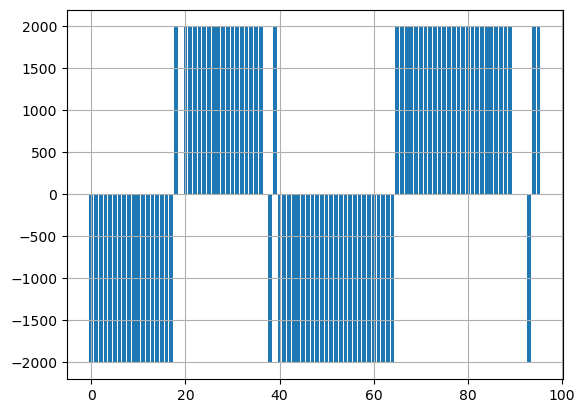

In [53]:
plt.bar(time, p_discharge - p_charge)
plt.grid(True)
plt.show()

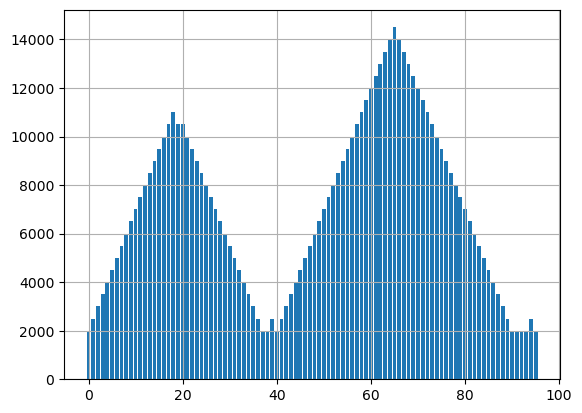

In [54]:
plt.bar(time, storage_soc)
plt.grid(True)
plt.show()

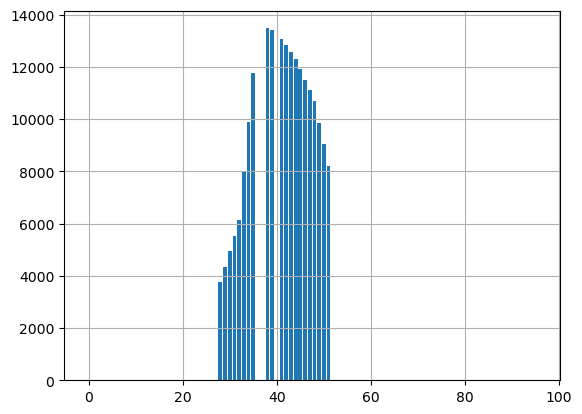

In [55]:
plt.bar(time, power_to_market_array)
plt.grid(True)

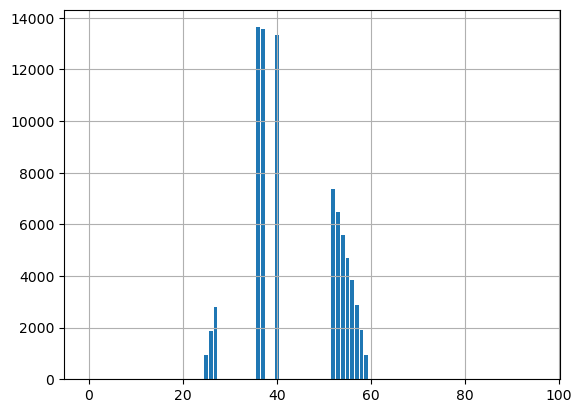

In [56]:
plt.bar(time, power_to_h2v_array)
plt.grid(True)

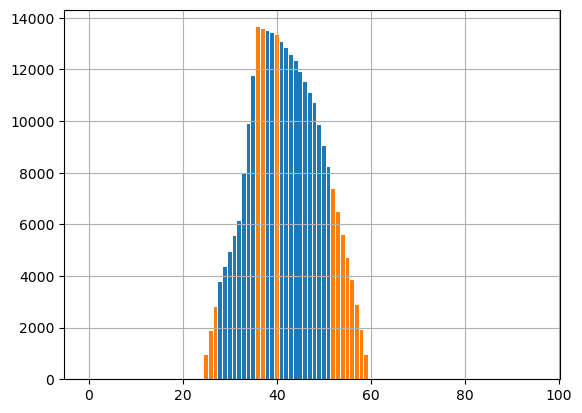

In [57]:
plt.bar(time, power_to_market_array)
plt.bar(time, power_to_h2v_array)
plt.grid(True)

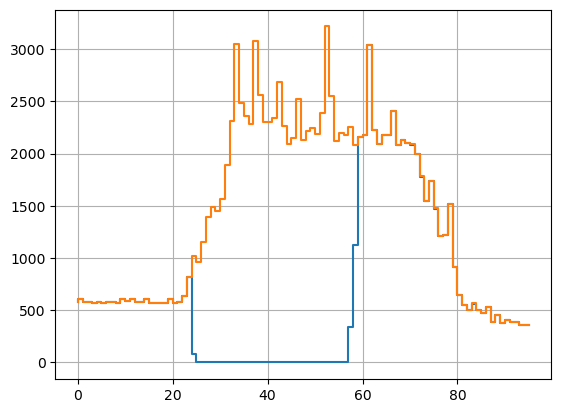

In [61]:
plt.step(time, power_from_grid)
plt.step(time, load.pload)
plt.grid(True)